In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import os

PAIRS = ['ETH_BTC', 'ETH_USDT', 'BTC_USDT', 'ETH_USD', 'BTC_USD']
BI_LEVELS = [5,10,15]

DATA_PATH_PREFIX = 'data_'
DATA_SUBSAMPLED_FOLDER = 'sampled_coe_dfs/oracle'

FILE_FOR_TRY = '1713886484276_1713882764_BI5.csv'



In [11]:
def get_train_test_splitted(data_path_prefix, pair, data_subsampled_folder, filename):
    coe_df = pd.read_csv(
        os.path.join(get_sampled_coe_dfs_folder(data_path_prefix, pair, data_subsampled_folder), filename)
    )
    regression_coe_df = coe_df[['Timestamp', 'BaseImbalance', 'Return']]
    train_coe_df = regression_coe_df[regression_coe_df['Timestamp'] < 1800][['BaseImbalance', 'Return']]
    X_train = train_coe_df[['BaseImbalance']]
    Y_train = train_coe_df[['Return']]

    test_coe_df = regression_coe_df[regression_coe_df['Timestamp'] >= 1800][['BaseImbalance', 'Return']]
    X_test = test_coe_df[['BaseImbalance']]
    Y_test = test_coe_df[['Return']]

    return X_train, Y_train, X_test, Y_test

def get_prediction_with_linear_regression(X_train, Y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, Y_train)

    return model.predict(X_test)

def get_sign_accuracy(Y_pred, Y_test):
    return (((Y_pred * Y_test) > 0).sum() / len(Y_pred))[0]

def get_sampled_coe_dfs_folder(
    data_path_prefix: str, pair: str, sampled_folder: str
) -> str:
    return os.path.join(data_path_prefix + pair, sampled_folder)

def get_accuracy_for_dfs_in_folder(data_path_prefix, pair, data_subsampled_folder, bi_level):
    dfs = os.listdir(get_sampled_coe_dfs_folder(data_path_prefix, pair, data_subsampled_folder))

    dfs = [df_filename for df_filename in dfs if df_filename.endswith(f'_BI{bi_level}.csv')]
    accuracies = []
    for df_filename in dfs:
        X_train, Y_train, X_test, Y_test = get_train_test_splitted(data_path_prefix, pair, data_subsampled_folder, df_filename)
        Y_pred = get_prediction_with_linear_regression(X_train, Y_train, X_test)
        accuracies.append(get_sign_accuracy(Y_pred, Y_test))
    return accuracies

def get_accuracy_for_all_bi_levels(data_path_prefix, pair, data_subsampled_folder, bi_levels):
    bi_level_accuracies_map = dict()

    for bi_level in bi_levels:
        accuracies = get_accuracy_for_dfs_in_folder(data_path_prefix, pair, data_subsampled_folder, bi_level)
        bi_level_accuracies_map[bi_level] = accuracies

    return bi_level_accuracies_map

def get_accuracy_for_all_pairs(data_path_prefix, pairs, data_subsampled_folder, bi_levels):
    pair_accuracies_map = dict()

    for pair in pairs:
        pair_accuracies_map[pair] = get_accuracy_for_all_bi_levels(data_path_prefix, pair, data_subsampled_folder, bi_levels)

    return pair_accuracies_map

def get_converted_accuracy_for_all_pairs_as_dataframe(pair_bi_accuracies_map):
    converted_accuracies = []
    for pair, bi_accuracies_map in pair_bi_accuracies_map.items():
        for bi_level, accuracies in bi_accuracies_map.items():
            for accuracy in accuracies:
                converted_accuracies.append([pair, bi_level, accuracy])

    return pd.DataFrame(converted_accuracies, columns=['Pair', 'BI Level', 'Accuracy'])

In [12]:
accuracy_for_all_pairs_map = get_accuracy_for_all_pairs(DATA_PATH_PREFIX, PAIRS, DATA_SUBSAMPLED_FOLDER, BI_LEVELS)
accuracy_df = get_converted_accuracy_for_all_pairs_as_dataframe(accuracy_for_all_pairs_map)
accuracy_df.head()

,Pair,BI Level,Accuracy
0,ETH_BTC,5,0.494949
1,ETH_BTC,5,0.544643
2,ETH_BTC,5,0.523810
3,ETH_BTC,5,0.327731
4,ETH_BTC,5,0.489583


In [15]:
# keep only the rows with the bi level that has the highest accuracy mean for each pair
accuracy_df = accuracy_df.groupby(['Pair', 'BI Level']).mean().reset_index()
accuracy_df = accuracy_df.loc[accuracy_df.groupby('Pair')['Accuracy'].idxmax()]
accuracy_df

,Pair,BI Level,Accuracy
0,BTC_USD,5,0.604497
4,BTC_USDT,10,0.570479
7,ETH_BTC,10,0.549379
9,ETH_USD,5,0.542817
13,ETH_USDT,10,0.577141


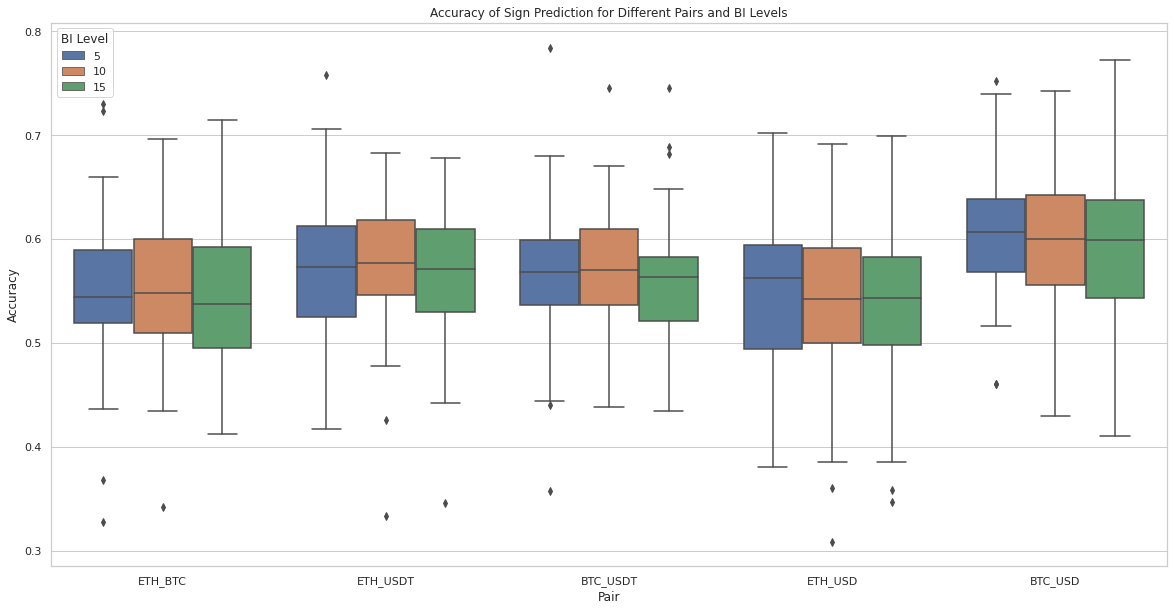

In [13]:
# plot the accuracy for each pair and bi level
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
sns.boxplot(x='Pair', y='Accuracy', hue='BI Level', data=accuracy_df)
plt.title('Accuracy of Sign Prediction for Different Pairs and BI Levels')
plt.show()